[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gerberlab/MDSINE2_Paper/blob/master/google_colab/colab_tutorial2_inference.ipynb)
# Running inference with the MDSINE2 model and exploring the posterior

This tutorial goes from parsing data to visualizing the posterior of an MDSINE2 run

For input MDSINE takes in
* taxa counts
* qPCR table
* perturbations table
* taxonomy table
* metadata file

Our data is preprocessed into pickle files as objects. For this tutorial we unpack our data into it's composite tables to walk you through constructing your own `Study` objects. We only keep the top 15 taxa for this tutorial though so that it runs in a reasonable amount of tome. We then run inference on those objects with a subset of the full taxa.


In [1]:
!git clone https://github.com/gerberlab/MDSINE2_Paper
!git clone https://github.com/gerberlab/MDSINE2
!pip install MDSINE2/.

fatal: destination path 'MDSINE2_Paper' already exists and is not an empty directory.
fatal: destination path 'MDSINE2' already exists and is not an empty directory.
Processing ./MDSINE2
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for mdsine2: filename=mdsine2-0.4.5-cp37-cp37m-linux_x86_64.whl size=331226 sha256=9c367d53f0941fcca7a9cda8ba2e124b35bed35dc4c5dc03f62ced9d3ad1755d
  Stored in directory: /tmp/pip-ephem-wheel-cache-jnngctal/wheels/b7/19/91/a6396303d26cbb96faa55fdede89eb0dbe3c598d2306ddb8b8
Successfully built mdsine2
  Attempting uninstall: mdsine2
    Found existing installation: mdsine2 0.4.5
    Uninstalling mdsi

In [2]:
%matplotlib inline

import mdsine2 as md2
from mdsine2.names import STRNAMES
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path

In [3]:
# set directories
output_dir = Path("MDSINE2_Paper/analysis/output/gibson-mini")
dataset_dir = output_dir / "datasets"

In [4]:
# Make example datasets from preprocessed data with 15 taxa
def make_toy(dset):
    to_delete = []
    for taxon in dset.taxa:
        if taxon.idx >= 15:   # you can adjust this number, top 15 taxa runs reasonably fast
            to_delete.append(taxon.name)
    dset.pop_taxa(to_delete)
    
    toy_dataset_path = dataset_dir / "{}-toy".format(dset.name)
    toy_dataset_path.mkdir(parents=True, exist_ok=True)
    
    dset.write_metadata_to_csv(path=toy_dataset_path / 'metadata.tsv')
    dset.write_qpcr_to_csv(path=toy_dataset_path / 'qpcr.tsv')
    if dset.perturbations is not None:
        dset.write_perturbations_to_csv(path=toy_dataset_path / 'perturbations.tsv')
    dset.write_reads_to_csv(path=toy_dataset_path / 'reads.tsv')
    dset.taxa.write_taxonomy_to_csv(path=toy_dataset_path / 'taxonomy.tsv')

In [5]:
healthy = md2.Study.load('MDSINE2_Paper/analysis/output/gibson/preprocessed/gibson_healthy_agg_taxa_filtered.pkl')
uc = md2.Study.load('MDSINE2_Paper/analysis/output/gibson/preprocessed/gibson_uc_agg_taxa_filtered.pkl')
replicates = md2.Study.load('MDSINE2_Paper/analysis/output/gibson/preprocessed/gibson_replicates_agg_taxa_filtered.pkl')

make_toy(dset=healthy)
make_toy(dset=uc)
make_toy(dset=replicates)

## Inputs for MDSINE2 model (looking at the Healthy cohort) 

### Metadata table
The following table is a metadata table. It tells the `Study` object what subject and timepoint each sample belongs to

In [ ]:
# Load metadata table
metadata = pd.read_csv(dataset_dir / 'healthy-toy' / 'metadata.tsv', sep='\t')
metadata.head()

,sampleID,subject,time
0,2-D10,2,10.0
1,2-D11,2,11.0
2,2-D14,2,14.0
3,2-D16,2,16.0
4,2-D18,2,18.0


### qPCR table
The following table is a qPCR table. This has the replicate measurements of the qPCR for every sample.

In [ ]:
# qPCR table
qpcr = pd.read_csv(dataset_dir / 'healthy-toy' / 'qpcr.tsv', sep='\t')
qpcr.head()

,sampleID,measurement1,measurement2,measurement3
0,2-D10,4.129004e+10,6.423568e+10,8.384557e+10
1,2-D11,2.981363e+10,6.587538e+10,5.077812e+10
2,2-D14,1.647771e+10,7.104907e+10,2.498869e+10
3,2-D16,3.666487e+10,6.237899e+10,3.875999e+10
4,2-D18,4.523257e+10,2.320504e+10,2.330249e+10


### Perturbation table
The following table is a perturbation table. This tells the `Study` object which subject has a perturbation and when. There can be multiple perturbations for each subject. Note that this is only necessary if you have perturbations in your dataset.

In [ ]:
perturbations = pd.read_csv(dataset_dir / 'healthy-toy' / 'perturbations.tsv', sep='\t')
display(perturbations)

,name,start,end,subject
0,High Fat Diet,21.5,28.5,2
1,High Fat Diet,21.5,28.5,3
2,High Fat Diet,21.5,28.5,4
3,High Fat Diet,21.5,28.5,5
4,Vancomycin,35.5,42.5,2
5,Vancomycin,35.5,42.5,3
6,Vancomycin,35.5,42.5,4
7,Vancomycin,35.5,42.5,5
8,Gentamicin,50.5,57.5,2
9,Gentamicin,50.5,57.5,3


### Reads table
The following table is a reads table. This shows the number of counts each taxa has for each sample ID.

In [ ]:
reads = pd.read_csv(dataset_dir / 'healthy-toy' / 'reads.tsv', sep='\t')
reads.head()

,name,2-D10,2-D11,2-D14,2-D16,2-D18,2-D1AM,2-D1PM,2-D21AM,2-D21PM,2-D22AM,2-D22PM,2-D23AM,2-D23PM,2-D24,2-D25,2-D28AM,2-D28PM,2-D29AM,2-D29PM,2-D2AM,2-D2PM,2-D30AM,2-D30PM,2-D31AM,2-D31PM,2-D32,2-D33,2-D35AM,2-D35PM,2-D36AM,2-D36PM,2-D37AM,2-D37PM,2-D38,2-D39,2-D3AM,2-D3PM,2-D42AM,2-D42PM,...,5-D3AM,5-D3PM,5-D42AM,5-D42PM,5-D43AM,5-D43PM,5-D44AM,5-D44PM,5-D45AM,5-D45PM,5-D46,5-D47,5-D4AM,5-D4PM,5-D5,5-D50AM,5-D50PM,5-D51AM,5-D51PM,5-D52AM,5-D52PM,5-D53,5-D54,5-D57AM,5-D57PM,5-D58AM,5-D58PM,5-D59AM,5-D59PM,5-D6,5-D60AM,5-D60PM,5-D61,5-D62,5-D63,5-D64AM,5-D64PM,5-D7,5-D8,5-D9
0,OTU_1,1227,1793,8023,9503,3243,1830,199,3539,5270,3866,3899,1984,807,2299,1349,1074,855,3479,3910,489,1056,5113,5624,7096,5788,10237,2784,2711,2421,1554,1216,259,154,114,100,1474,3227,1963,2950,...,1198,3491,395,38,60,35,96,136,38,27,137,162,3943,5485,5746,49,103,39,80,222,205,115,29,73,135,140,223,83,192,6401,218,409,2072,1160,723,1043,1732,4698,3310,4495
1,OTU_2,17362,6887,17165,29854,36759,2929,9880,15863,20619,2725,1792,466,51,86,38,25,34,1317,2217,24422,17184,5490,5924,6906,7466,9783,7856,10490,9939,18164,17769,16694,8553,8842,5806,11193,15984,8567,6995,...,14848,19560,4414,4235,2542,2997,3094,4063,2390,3151,4671,10280,17736,21286,15239,8966,11075,9328,9982,11443,10228,1803,3863,3611,3487,2979,3613,4359,5351,16153,3483,5742,10560,6931,7609,9301,10964,14754,6195,7539
2,OTU_3,8162,4911,9743,5776,11136,213,555,8566,12664,21003,19170,19830,16629,14891,31789,15839,13884,10019,15779,878,4879,7562,9470,11915,16469,13191,9874,8836,6895,5094,14544,2291,1194,458,116,5842,8939,126,23,...,10501,5094,1038,31,19,18,34,73,8584,2989,3627,8577,7146,6964,9184,2135,1258,1001,1042,384,473,59,25,29,9,1,8,10,8,5602,7,51,2039,2944,9708,1664,2578,8830,3163,6160
3,OTU_4,3793,2713,2683,3423,5351,9,32,3815,6512,1091,617,215,318,273,551,366,209,2626,3040,205,264,4519,5056,4976,4818,1757,4139,5070,5575,7195,7188,18681,20984,13723,7217,203,371,3507,3929,...,522,939,2162,3243,3182,6006,6912,9189,8061,11804,18394,26639,1059,1343,1669,13609,16459,11413,10262,11874,11321,11560,9360,5699,3794,9114,8111,11557,11729,1477,8539,12437,15397,6717,4179,3597,5020,1395,895,2242
4,OTU_5,5852,3034,6870,6102,9957,2,7,4626,6412,691,503,197,388,172,289,162,186,2677,1548,71,84,1740,1395,2559,1266,2868,3018,2967,3276,9350,9143,707,313,77,350,895,1121,214,284,...,5,0,164,134,40,6,16,76,37,28,120,407,7,7,17,368,520,422,533,1282,2093,4278,2660,3503,3842,1051,1447,2867,3844,4320,1855,3481,5015,3096,2779,3302,1941,4893,2275,1903


### Taxonomy table
The following table is a taxonomy table. For each taxa name, it shows the sequence and taxonomy

In [ ]:
taxonomy = pd.read_csv(dataset_dir / 'healthy-toy' / 'taxonomy.tsv', sep='\t')
display(taxonomy)

,name,sequence,kingdom,phylum,class,order,family,genus,species
0,OTU_1,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,NaN
1,OTU_2,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,fragilis/ovatus
2,OTU_3,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Akkermansiaceae,Akkermansia,muciniphila
3,OTU_4,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,NaN
4,OTU_5,TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGGGTG...,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Sutterellaceae,Parasutterella,excrementihominis
5,OTU_6,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,dorei/fragilis
6,OTU_7,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,caccae
7,OTU_8,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,salyersiae
8,OTU_9,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,NaN
9,OTU_10,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,uniformis


With these 5 tables, you can run our model. You can parse them directly into a `Study` object with the `mdsine2.dataset.parse` command:

In [9]:
h_toy = md2.dataset.parse(name='healthy-toy-dataset', 
                         taxonomy=dataset_dir / 'healthy-toy' / 'taxonomy.tsv', 
                         reads=dataset_dir / 'healthy-toy' / 'reads.tsv', 
                         qpcr=dataset_dir / 'healthy-toy' / 'qpcr.tsv', 
                         perturbations=dataset_dir / 'healthy-toy' / 'perturbations.tsv', 
                         metadata=dataset_dir / 'healthy-toy' / 'metadata.tsv')
uc_toy = md2.dataset.parse(name='uc-toy-dataset', 
                         taxonomy=dataset_dir / 'uc-toy' / 'taxonomy.tsv', 
                         reads=dataset_dir / 'uc-toy' / 'reads.tsv', 
                         qpcr=dataset_dir / 'uc-toy' / 'qpcr.tsv', 
                         perturbations=dataset_dir / 'uc-toy' / 'perturbations.tsv', 
                         metadata=dataset_dir / 'uc-toy' / 'metadata.tsv')
rep_toy = md2.dataset.parse(name='replicates-toy-dataset', 
                         taxonomy=dataset_dir / 'replicates-toy' / 'taxonomy.tsv', 
                         reads=dataset_dir / 'replicates-toy' / 'reads.tsv', 
                         qpcr=dataset_dir / 'replicates-toy' / 'qpcr.tsv', 
                         metadata=dataset_dir / 'replicates-toy' / 'metadata.tsv')


2021-12-15 21:32:36,937 [INFO] [base.py (1286)] - TaxaSet parsng new taxonomy table. Resetting
2021-12-15 21:32:37,102 [INFO] [base.py (1286)] - TaxaSet parsng new taxonomy table. Resetting
2021-12-15 21:32:37,301 [INFO] [base.py (1286)] - TaxaSet parsng new taxonomy table. Resetting


Once you read these into the parser they are identical to the data stored in our pickles files (we only kept the top 15 most abundant taxa so that this tutorial could run in a reasonable amount of time). If you wanted to run a model on your own cohort you would simply replace the 5 files with your own.

# Learning the Negative Binomial dispersion parameters

Before running the main inference loop we learn the negative binomial parameters from our physical replicates

In [10]:
# set negative binomial model inference parameters
params = md2.config.NegBinConfig(
    seed=0, burnin=100, n_samples=200,
    checkpoint=100, 
    basepath=str(output_dir / "negbin")
)

Build the compute graph for learning the model that is used to learn negative binomial parameters.

In [11]:
mcmc_negbin = md2.negbin.build_graph(
    params=params, 
    graph_name=rep_toy.name, 
    subjset=rep_toy
)

2021-12-15 21:32:38,835 [INFO] [inference.py (591)] - Setting Single Write, Multiple Read Mode
2021-12-15 21:32:38,837 [INFO] [inference.py (596)] - Setting the trace of learned parameters
2021-12-15 21:32:38,839 [INFO] [inference.py (597)] - #######################################
2021-12-15 21:32:38,841 [INFO] [inference.py (599)] - Setting the trace of Negative binomial dispersion a0
2021-12-15 21:32:38,851 [INFO] [inference.py (599)] - Setting the trace of Negative binomial dispersion a1
2021-12-15 21:32:38,855 [INFO] [inference.py (599)] - Setting the trace of Filtering
2021-12-15 21:32:38,865 [INFO] [inference.py (601)] - Setting the trace for diagnostic variables
2021-12-15 21:32:38,868 [INFO] [inference.py (602)] - ##########################################


Run inference to learn the negative binomial parameters

In [12]:
mcmc_negbin = md2.negbin.run_graph(
    mcmc_negbin, 
    crash_if_error=True
)

100%|██████████| 200/200 [00:02<00:00, 96.78it/s] 
2021-12-15 21:32:42,257 [INFO] [inference.py (510)] - Inference total time: 0.010384842157363891/Gibb step
2021-12-15 21:32:42,262 [INFO] [inference.py (514)] - remove local traces


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


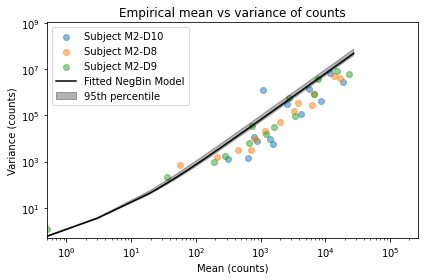

In [113]:
# visualize fit
fig = md2.negbin.visualize_learned_negative_binomial_model(mcmc_negbin)
fig.tight_layout()
plt.show()

This is not representative of the real results because we only have the 15 of the most abundant taxa here.

In [22]:
# summary of a0 and a1 posterior
print('a0', md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A0]))
print('a1', md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A1]))

a0 {'median': 2.0149169537426792e-10, 'mean': 1.9940356992343302e-10, '25th percentile': 1.7354531823501396e-10, '75th percentile': 2.2558396649358908e-10}
a1 {'median': 0.06466732367084299, 'mean': 0.06562195000302486, '25th percentile': 0.05899503076607574, '75th percentile': 0.06842424704123246}


# Run inference on the full model (with seed=0)

### Initialize and set model hyperparameters

In [23]:
# Get a0 and a1 from negbin (get the mean of the posterior) and fixes them for inference
from mdsine2.names import STRNAMES
a0 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A0])['mean']
a1 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A1])['mean']

print('negbin a0', a0)
print('negbin a1', a1)

basepath = output_dir / "mdsine2" / "uc0"
basepath.mkdir(exist_ok=True, parents=True)

# Initialize parameters of the model (Seed = 0) burnin=50, total steps=100
params = md2.config.MDSINE2ModelConfig(
    basepath=str(basepath), 
    seed=0,
    burnin=50, 
    n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, 
    checkpoint=50
)

# The default number of modules is 30, which is larger than the number of taxa
# that we have in this dataset, which would throw a flag.
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'

negbin a0 1.9940356992343302e-10
negbin a1 0.06562195000302486


In [28]:
# initilize the graph
mcmc_uc0 = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)


2021-12-15 22:30:28,151 [INFO] [base.py (2777)] - max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
2021-12-15 22:30:28,191 [INFO] [run.py (87)] - Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
2021-12-15 22:30:28,413 [INFO] [run.py (254)] - There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
2021-12-15 22:30:28,425 [INFO] [run.py (289)] - Initializing Filtering
2021-12-15 22:30:28,426 [INFO] [posterior.py (2658)] - Setting up the essential timepoints
2021-12-15 22:30:28,429 [INFO] [posterior.py (2671)] - Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.
 11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5
 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5
 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5
 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5
 61.  62.  63.  64. 

### Perform inference

In [29]:
mcmc_uc0 = md2.run_graph(mcmc_uc0, crash_if_error=True)

100%|██████████| 100/100 [01:07<00:00,  1.48it/s]
2021-12-15 22:31:41,408 [INFO] [inference.py (510)] - Inference total time: 0.6780181789398193/Gibb step
2021-12-15 22:31:41,410 [INFO] [inference.py (514)] - remove local traces
2021-12-15 22:31:41,459 [INFO] [run.py (545)] - Denormalizing the parameters


### Visualize posteriors

#### growth rates

Mean growth rates for taxa over posterior [0.70182608 0.42527662 0.66947014 0.14852835 0.58609608 0.68488235
 0.40004264 0.48001883 0.17211125 0.19082563 0.5226722  0.22349709
 1.02113932 1.00788873 0.39988464]


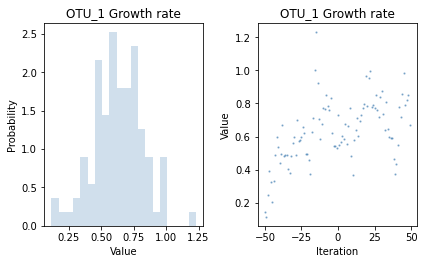

In [112]:
growth = mcmc_uc0.graph[STRNAMES.GROWTH_VALUE]
growth_rates_trace = growth.get_trace_from_disk(section='entire')

growth_rates_mean = md2.summary(growth)['mean']
print('Mean growth rates for taxa over posterior', growth_rates_mean)

# visualize trace for the first taxa
md2.visualization.render_trace(growth_rates_trace[:,0], n_burnin=50, **{'title': 'OTU_1 Growth rate'})
plt.show()

#### Process variance

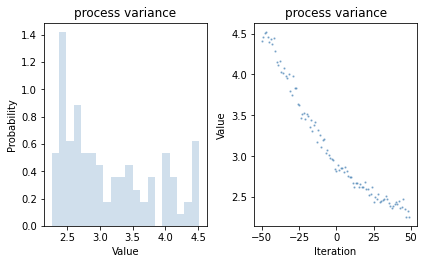

In [114]:
processvar = mcmc_uc0.graph[STRNAMES.PROCESSVAR]
pv_rates_trace = processvar.get_trace_from_disk(section='entire')

md2.visualization.render_trace(pv_rates_trace, n_burnin=50, **{'title': 'process variance'})
plt.show()

#### taxa module assigments

2021-12-16 02:00:45,092 [INFO] [util.py (173)] - Number of clusters: 2
2021-12-16 02:00:45,100 [INFO] [util.py (179)] - Clusters assigned: [0 0 0 0 0 1 0 0 0 0 0 0 1 1 0]


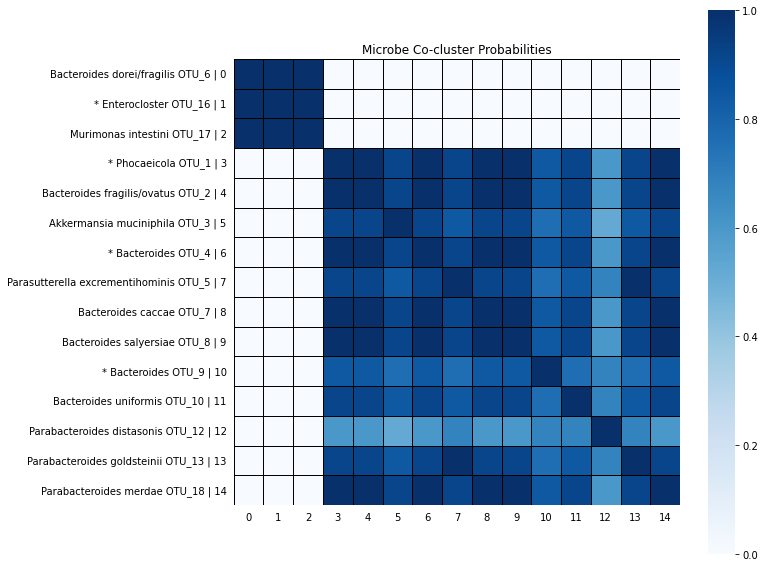

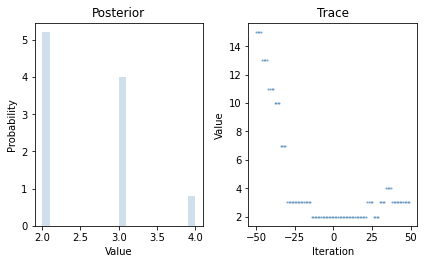

In [110]:
clustering = mcmc_uc0.graph[STRNAMES.CLUSTERING_OBJ]
md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
taxa = mcmc_uc0.graph.data.taxa

# Visualize co-cluster posterior probability
coclusters = md2.summary(mcmc_uc0.graph[STRNAMES.CLUSTERING_OBJ].coclusters)['mean']
md2.visualization.render_cocluster_probabilities(coclusters, taxa=uc_toy.taxa,
    yticklabels='%(paperformat)s | %(index)s', order=order)

# Visualize trace for number of modules
md2.visualization.render_trace(clustering.n_clusters)
plt.show()

All model parameters have traces and can be visualized in a similar fashion. All `STRNAMES` can be found here https://github.com/gerberlab/MDSINE2/blob/master/mdsine2/names.py


# Run inference on the full model again, but with a different seed (seed=1)

In [116]:
uc1_basepath = output_dir / 'mdsine2' / 'uc1'
uc1_basepath.mkdir(exist_ok=True)

params = md2.config.MDSINE2ModelConfig(
    basepath=uc1_basepath, 
    seed=1, 
    burnin=50, 
    n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, 
    checkpoint=50)
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
mcmc_uc1 = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)
mcmc_uc1 = md2.run_graph(mcmc_uc1, crash_if_error=True)


2021-12-16 02:03:17,573 [INFO] [base.py (2777)] - max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
2021-12-16 02:03:17,602 [INFO] [run.py (87)] - Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
2021-12-16 02:03:17,644 [INFO] [run.py (254)] - There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
2021-12-16 02:03:17,654 [INFO] [run.py (289)] - Initializing Filtering
2021-12-16 02:03:17,657 [INFO] [posterior.py (2658)] - Setting up the essential timepoints
2021-12-16 02:03:17,661 [INFO] [posterior.py (2671)] - Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.
 11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5
 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5
 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5
 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5
 61.  62.  63.  64. 

Mean growth rates for taxa over posterior [0.63223404 0.52088593 0.6489859  0.26341507 0.56218366 0.66907369
 0.57298975 0.4731844  0.21922015 0.21572884 0.52540263 0.27600863
 1.13457336 0.98020719 0.61079102]
2021-12-16 02:04:29,398 [INFO] [util.py (173)] - Number of clusters: 3
2021-12-16 02:04:29,403 [INFO] [util.py (179)] - Clusters assigned: [0 0 0 0 0 1 1 0 2 0 2 0 1 1 1]


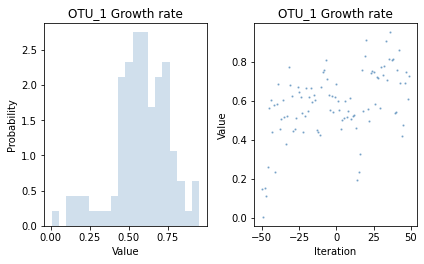

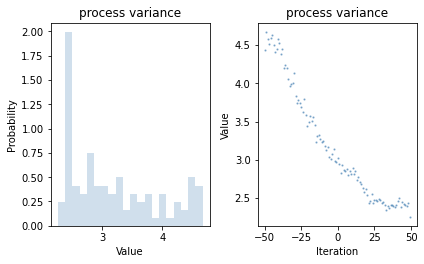

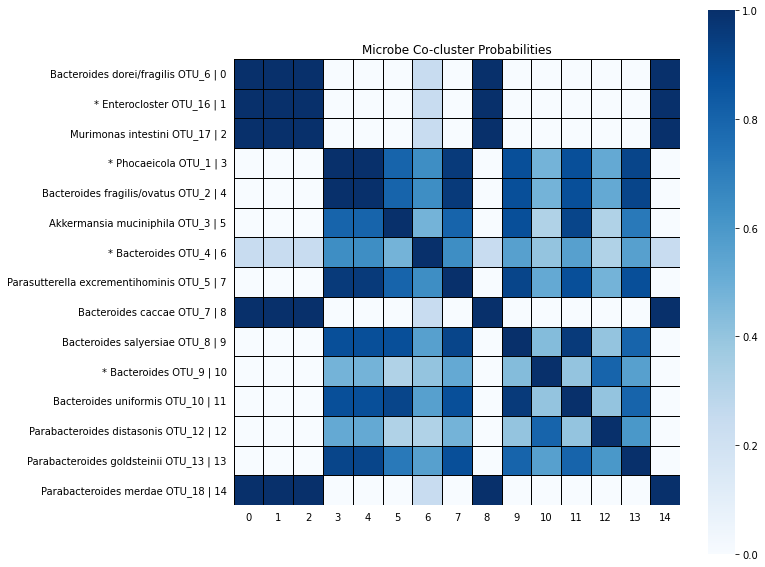

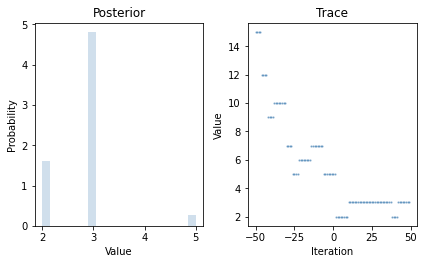

In [117]:
# growth rate
growth = mcmc_uc1.graph[STRNAMES.GROWTH_VALUE]
growth_rates_trace = growth.get_trace_from_disk(section='entire')

growth_rates_mean = md2.summary(growth)['mean']
print('Mean growth rates for taxa over posterior', growth_rates_mean)

# visualize trace for the first taxa
md2.visualization.render_trace(growth_rates_trace[:,0], n_burnin=50, **{'title': 'OTU_1 Growth rate'})

#process var
processvar = mcmc_uc1.graph[STRNAMES.PROCESSVAR]
pv_rates_trace = processvar.get_trace_from_disk(section='entire')

md2.visualization.render_trace(pv_rates_trace, n_burnin=50, **{'title': 'process variance'})

# module assignments

clustering = mcmc_uc1.graph[STRNAMES.CLUSTERING_OBJ]
md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
taxa = mcmc_uc0.graph.data.taxa

# Visualize co-cluster posterior probability
coclusters = md2.summary(mcmc_uc1.graph[STRNAMES.CLUSTERING_OBJ].coclusters)['mean']
md2.visualization.render_cocluster_probabilities(coclusters, taxa=uc_toy.taxa,
    yticklabels='%(paperformat)s | %(index)s', order=order)

# Visualize trace for number of modules
md2.visualization.render_trace(clustering.n_clusters)

plt.show()


# Compute $\hat r$ statistic on model parameters to assess mixing

In [ ]:
chains = [mcmc_uc0, mcmc_uc1]
start = 10
end = 20
vname = STRNAMES.GROWTH_VALUE

rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Growth parameter r-hat:', rhat)

vname = STRNAMES.CONCENTRATION
rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Concentration parameter r-hat:', rhat)

vname = STRNAMES.PROCESSVAR
rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Process variance parameter r-hat:', rhat)


Growth parameter r-hat: [2.03354699 2.27293867 1.6792325  1.71052518 1.64383609 1.76505317
 1.65660989 1.64882678 1.65598663 1.66534829 2.28150285 1.66107476
 1.72406894 1.73453694 1.72608957]
Concentration parameter r-hat: [1.61910602]
Process variance parameter r-hat: [4.32587727]


These are not good $\hat r$ values, but we only have 50 posterior samples. For the paper the posterior is 10,000 Gibbs steps

# Consensus clustering
Run the model with module assignments fixed (to their most likely module assignment learned from the previous step)

In [118]:
basepath = output_dir / 'mdsine2-fixed-cluster'
basepath.mkdir(exist_ok=True)

# Use the clustering from a previous as the clustering assignment
params = md2.config.MDSINE2ModelConfig(
    basepath=basepath, seed=0, burnin=50, n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, checkpoint=50)

# Do not learn the clustering parameters
params.LEARN[STRNAMES.CLUSTERING] = False
params.LEARN[STRNAMES.CONCENTRATION] = False

# Set the initialization option for clustering
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'fixed-clustering'
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value'] = str(uc1_basepath / "mcmc.pkl")

mcmc = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)
mcmc = md2.run_graph(mcmc, crash_if_error=True)

2021-12-16 02:06:14,701 [INFO] [base.py (2777)] - max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
2021-12-16 02:06:14,730 [INFO] [run.py (87)] - Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
2021-12-16 02:06:14,770 [INFO] [run.py (254)] - There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
2021-12-16 02:06:14,780 [INFO] [run.py (289)] - Initializing Filtering
2021-12-16 02:06:14,782 [INFO] [posterior.py (2658)] - Setting up the essential timepoints
2021-12-16 02:06:14,787 [INFO] [posterior.py (2671)] - Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.
 11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5
 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5
 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5
 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5
 61.  62.  63.  64. 

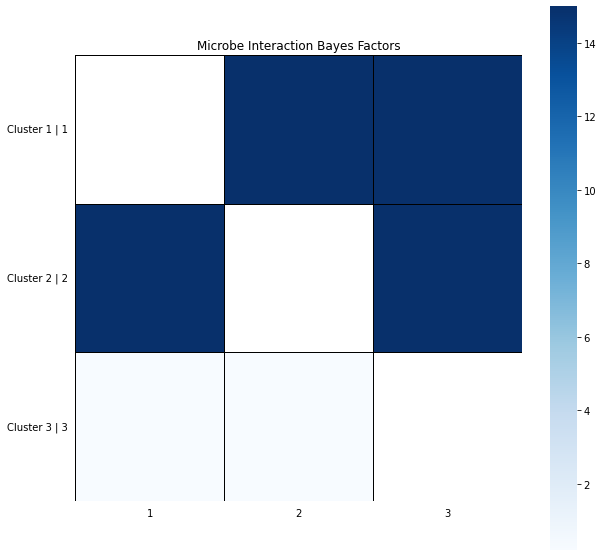

In [119]:
# Plot bayes factors for module-module interactions
clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
bf_taxa = md2.generate_interation_bayes_factors_posthoc(mcmc)
bf_clustering = md2.condense_fixed_clustering_interaction_matrix(bf_taxa, clustering=clustering)

labels = ['Cluster {} | {}'.format(i+1, i+1) for i in range(len(clustering))]
md2.visualization.render_bayes_factors(bf_clustering, yticklabels=labels)
plt.show()

# Cross validation Example

Take out a single subject, perform inference on the rest, and then forward simulate from initial condition of held out subject

In [120]:
# Make the data and validation Study objects
holdout_study = md2.dataset.parse(
    name='uc-toy-dataset', 
    taxonomy=dataset_dir / 'uc-toy' / 'taxonomy.tsv', 
    reads=dataset_dir / 'uc-toy' / 'reads.tsv', 
    qpcr=dataset_dir / 'uc-toy' / 'qpcr.tsv', 
    perturbations=dataset_dir / 'uc-toy' / 'perturbations.tsv', 
    metadata=dataset_dir / 'uc-toy' / 'metadata.tsv'
)

#remove subject 8
val = holdout_study.pop_subject('8')
val.name += '-validate'

print(holdout_study.name)
for subj in holdout_study:
    print(subj.name)
for pert in holdout_study.perturbations:
    print(pert)
print()
print(val.name)
for subj in val:
    print(subj.name)
for pert in val.perturbations:
    print(pert)


2021-12-16 02:07:32,048 [INFO] [base.py (1286)] - TaxaSet parsng new taxonomy table. Resetting
uc-toy-dataset
10
6
7
9
Perturbation High Fat Diet:
	Subject 6: (21.5, 28.5)
	Subject 7: (21.5, 28.5)
	Subject 9: (21.5, 28.5)
	Subject 10: (21.5, 28.5)

Perturbation Vancomycin:
	Subject 6: (35.5, 42.5)
	Subject 7: (35.5, 42.5)
	Subject 9: (35.5, 42.5)
	Subject 10: (35.5, 42.5)

Perturbation Gentamicin:
	Subject 6: (50.5, 57.5)
	Subject 7: (50.5, 57.5)
	Subject 9: (50.5, 57.5)
	Subject 10: (50.5, 57.5)


unnamed-study-validate
8
Perturbation High Fat Diet:
	Subject 8: (21.5, 28.5)

Perturbation Vancomycin:
	Subject 8: (35.5, 42.5)

Perturbation Gentamicin:
	Subject 8: (50.5, 57.5)



In [121]:
cv_output_dir = output_dir / "cv"

# Learn the model
params = md2.config.MDSINE2ModelConfig(
    basepath=cv_output_dir / holdout_study.name, 
    seed=0, 
    burnin=50, n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, 
    checkpoint=50
)
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
mcmc = md2.initialize_graph(params=params, graph_name=holdout_study.name, subjset=holdout_study)
mcmc = md2.run_graph(mcmc, crash_if_error=True)

2021-12-16 02:07:35,627 [INFO] [base.py (2777)] - max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
2021-12-16 02:07:35,649 [INFO] [run.py (87)] - Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
2021-12-16 02:07:35,681 [INFO] [run.py (254)] - There are 297 qPCR measurements for 3 buckets. Each bucket is 99 measurements long
2021-12-16 02:07:35,688 [INFO] [run.py (289)] - Initializing Filtering
2021-12-16 02:07:35,690 [INFO] [posterior.py (2658)] - Setting up the essential timepoints
2021-12-16 02:07:35,696 [INFO] [posterior.py (2671)] - Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.
 11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5
 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5
 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5
 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5
 61.  62.  63.  64.  

In [124]:
# Forward simulate

# Get the initial conditions
subj = val['8']
M_truth = subj.matrix()['abs']
initial_conditions = M_truth[:,0]
initial_conditions[initial_conditions==0] = 1e5
times = subj.times

# Forward simulate for each gibb step
M = md2.model.gLVDynamicsSingleClustering.forward_sim_from_chain(
    mcmc, subj=subj, 
    initial_conditions=initial_conditions, 
    times=times, 
    simulation_dt=0.01
)


2021-12-16 02:09:16,912 [INFO] [model.py (215)] - 5/50 - 0.5103380680084229
2021-12-16 02:09:17,449 [INFO] [model.py (215)] - 10/50 - 0.5357308387756348
2021-12-16 02:09:17,967 [INFO] [model.py (215)] - 15/50 - 0.515347957611084
2021-12-16 02:09:18,485 [INFO] [model.py (215)] - 20/50 - 0.5162489414215088
2021-12-16 02:09:19,001 [INFO] [model.py (215)] - 25/50 - 0.5142722129821777
2021-12-16 02:09:19,525 [INFO] [model.py (215)] - 30/50 - 0.5218789577484131
2021-12-16 02:09:20,056 [INFO] [model.py (215)] - 35/50 - 0.528860330581665
2021-12-16 02:09:20,596 [INFO] [model.py (215)] - 40/50 - 0.5376591682434082
2021-12-16 02:09:21,135 [INFO] [model.py (215)] - 45/50 - 0.5367293357849121


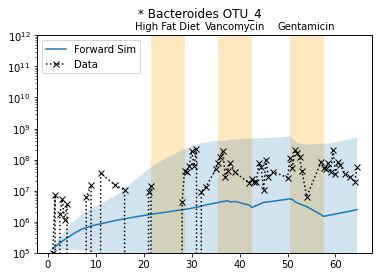

In [126]:
# Plot the forward sims, 5th-95th percentile
taxa = subj.taxa

low = np.percentile(M, q=5, axis=0)
high = np.percentile(M, q=95, axis=0)
med = np.percentile(M, q=50, axis=0)

oidx = 3 # OTU 4

fig = plt.figure()
ax = fig.add_subplot(111)
ax.fill_between(times, y1=low[oidx, :], y2=high[oidx, :], alpha=0.2)
ax.plot(times, med[oidx,:], label='Forward Sim')
ax.plot(times, M_truth[oidx, :], label='Data', marker='x', color='black',
       linestyle=':')
ax.set_yscale('log')

md2.visualization.shade_in_perturbations(ax, perturbations=subj.perturbations, subj=subj)
ax.set_ylim(bottom=1e5, top=1e12)

ax.legend()

fig.suptitle(md2.taxaname_for_paper(taxa[oidx], taxa))
plt.show()